# BENCHMARK MODELS

The notebook includes benchmark models of BERT (the main model) for category detection. I followed a chronological pattern for the benchmarks beginning with the basic machine learning algorithms (naive Bayes, SVM and Logit), the RNNs(LSTM & BiLSTM) and CNN and lastly ELMo. 

I thought that the first switch is from the basic MLs to neural networks. The second is unidirectional NN (LSTM) to bidirectional or non-directional NNs (BiLSTM and CNN), then from uncontextualized embedding to contextualized embedding of words(ELMo).

Last switch is applying a brand new approach on neural network architecture through attention mechanism with BERT.


## Packages

In [ ]:
!pip install contractions

     |████████████████████████████████| 317kB 4.5MB/s 
     |████████████████████████████████| 245kB 8.2MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81697 sha256=ca7ca8d14bc81637e3057bd773f6bd806e09d93566ab3ad0f2b7102120d71945
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [ ]:
import contractions
import keras
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
import numpy as np
import pandas as pd
import re
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub

from keras.layers.advanced_activations import LeakyReLU
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, average_precision_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score, hamming_loss, precision_score, roc_auc_score, roc_curve, recall_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import m
from string import digits
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Dropout, Bidirectional, Input, Lambda
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Cleaning & Descriptive Analytics

In [ ]:
# Import data
train = pd.read_excel('Trainset.xlsx')
test = pd.read_excel('Testset.xlsx')

# Eliminate the NAs
train = train.fillna('')
test = test.fillna('')

# Remove the rows without Opinion Category values
train = train[train.OpinionCategory != ''] 
test = test[test.OpinionCategory != ''] 

# Sort the data
train = train.sort_values('Sentence_ID').reset_index(drop=True)
test = test.sort_values('Sentence_ID').reset_index(drop=True)

train.head()

,ID_number,Review_ID,ID_and_Review,OutOfScope,Sentence_ID,OpinionCategory,OpinionFrom,Polarity,AspectTerm,OpinionTo,Text
0,1004293,1,1004293:0,,1,RESTAURANT#GENERAL,51,negative,place,56,Judging from previous posts this used to be a ...
1,1004293,1,1004293:1,,2,SERVICE#GENERAL,75,negative,staff,80,"We, there were four of us, arrived at noon - t..."
2,1004293,1,1004293:2,,3,SERVICE#GENERAL,0,negative,,0,"They never brought us complimentary noodles, i..."
3,1004293,1,1004293:3,,4,FOOD#QUALITY,4,negative,food,8,The food was lousy - too sweet or too salty an...
4,1004293,1,1004293:3,,4,FOOD#STYLE_OPTIONS,52,negative,portions,60,The food was lousy - too sweet or too salty an...


## Multilabeling

Since many reviews have more than one aspect, it is necessary to map them to multilabel one hot encodings.

In [ ]:
# First, one-hot encode each sentence (duplicate ones as well)
train.OpinionCategory = train.OpinionCategory.astype('category')
one_hot = to_categorical(train.OpinionCategory.cat.codes)
one_hot = pd.DataFrame(one_hot)

test.OpinionCategory = test.OpinionCategory.astype('category')
one_hot_test = to_categorical(test.OpinionCategory.cat.codes)
one_hot_test = pd.DataFrame(one_hot_test)

one_hot.shape, one_hot_test.shape

((2507, 12), (859, 12))

In [ ]:
# Subtract the necessary columns for the analysis
useful_train = train[['Sentence_ID','OpinionCategory','Text']]
useful_test = test[['Sentence_ID','OpinionCategory','Text']]

In [ ]:
# Concatenate the train data and the one-hot-encoding of the opinion category classes.
data_train = pd.concat([useful_train, one_hot], axis=1)
data_test = pd.concat([useful_test, one_hot_test], axis=1)

# Since the reviewer may have mentioned more than one opinion in a sentence, 
# Sum up the one-hot-encoded classes of each sentence.
multi_label = data_train.groupby('Sentence_ID').sum().reset_index(drop=True)
multi_label_test = data_test.groupby('Sentence_ID').sum().reset_index(drop=True)

# In each sentence, an opinion category may be refered more than one.
# Because of that, there were values besides 0 and 1, after the summation.
# Since being refered is important rather than how many times, the values such as 2 or 3 are reverted to one.
multi_label = np.array(multi_label.astype(bool).astype(int))
multi_label_test = np.array(multi_label_test.astype(bool).astype(int))

# After the multi-labeling of the sentences, remove the duplicates.
train_Text = data_train.drop_duplicates(subset=['Sentence_ID'], keep='last').Text
test_Text = data_test.drop_duplicates(subset=['Sentence_ID'], keep='last').Text

multi_label, multi_label.shape, multi_label_test, multi_label_test.shape

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]]), (1708, 12), array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 1],
        [0, 0, 0, ..., 0, 0, 0]]), (587, 12))

### Label Counts

In [ ]:
# To elobarate the results of the models, it is important to know the number of comments under each category.
# This also shows if the data is imbalanced or not.
counts = []
categories = list(sorted(useful_train.OpinionCategory.values.unique()))
for i in categories:
    counts.append((i, len(useful_train[useful_train.OpinionCategory == i])))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,AMBIENCE#GENERAL,255
1,DRINKS#PRICES,20
2,DRINKS#QUALITY,47
3,DRINKS#STYLE_OPTIONS,32
4,FOOD#PRICES,90
5,FOOD#QUALITY,849
6,FOOD#STYLE_OPTIONS,137
7,LOCATION#GENERAL,28
8,RESTAURANT#GENERAL,422
9,RESTAURANT#MISCELLANEOUS,98


Text(0.5, 0, 'category')

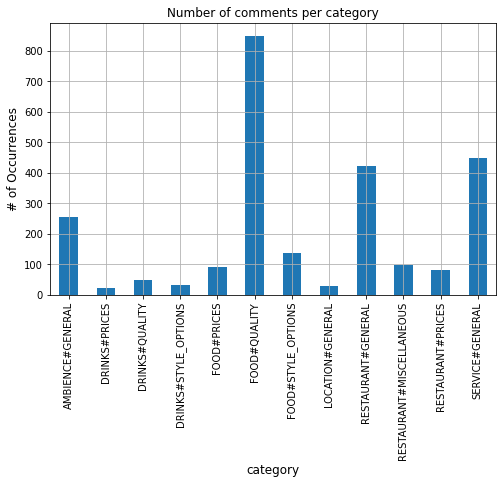

In [ ]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

### How many multilabels?

In [ ]:
row_sums = np.sum(multi_label, axis = 1)
unique_sums = list(set(row_sums))

counts = []
for i in unique_sums:
    counts.append(row_sums.tolist().count(i))
df_multi = pd.DataFrame({'multi_labels':unique_sums, 'counts_of_multi':counts})
df_multi

,multi_labels,counts_of_multi
0,1,1282
1,2,324
2,3,83
3,4,17
4,5,1
5,6,1


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, '# of categories')

<Figure size 432x288 with 0 Axes>

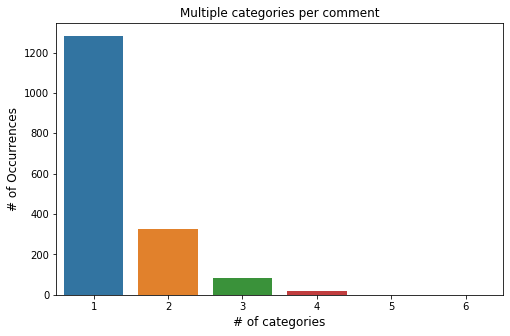

In [ ]:
#plot
plt.clf()
plt.figure(figsize=(8,5))
ax = sns.barplot(df_multi.multi_labels, df_multi.counts_of_multi)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

## Train & Test Data Cleaning

In [ ]:
# Reset the indexes to remove confusion in next steps
train_Text = train_Text.astype('str').reset_index(drop = True)
test_Text = test_Text.astype('str').reset_index(drop = True)
train_Text

0       Judging from previous posts this used to be a ...
1       We, there were four of us, arrived at noon - t...
2       They never brought us complimentary noodles, i...
3       The food was lousy - too sweet or too salty an...
4       After all that, they complained to me about th...
                              ...                        
1703    I can't believe that it was, but please put th...
1704    The waitress came to check in on us every few ...
1705    I couldn't ignore the fact that she reach over...
1706    She then put the check down without asking if ...
1707    I wish I could like this place more, and I wis...
Name: Text, Length: 1708, dtype: object

In [ ]:
def cleanText(text):
    text = contractions.fix(text) # fix the contractions (such as I've = I have)
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE) # remove urls
    text = ''.join([i for i in text if not i.isdigit()]) # remove numbers
    text = re.sub(r'[,!@#$%^&*)(|/><";:.?\'\\}{]',"",text) # remove punctuations
    text = text.lower() # make lower case
    return text

In [ ]:
train_Text = train_Text.astype(str).map(lambda x: cleanText(x))
test_Text = test_Text.astype(str).map(lambda x: cleanText(x))
train_Text

0       judging from previous posts this used to be a ...
1       we there were four of us arrived at noon - the...
2       they never brought us complimentary noodles ig...
3       the food was lousy - too sweet or too salty an...
4       after all that they complained to me about the...
                              ...                        
1703    i can not believe that it was but please put t...
1704    the waitress came to check in on us every few ...
1705    i could not ignore the fact that she reach ove...
1706    she then put the check down without asking if ...
1707    i wish i could like this place more and i wish...
Name: Text, Length: 1708, dtype: object

## Aspect Term Cleaning

Aspect terms are used for multi input LSTM and multi input BiLSTM models.

In [ ]:
train_df = pd.DataFrame(train_Text).reset_index(drop=True)
test_df = pd.DataFrame(test_Text).reset_index(drop=True)

aspect_list = []
for i in range((max(train.Sentence_ID))):
    if any(train.Sentence_ID == i+1) == True:
        aspect_list.append(train.groupby(['Sentence_ID']).get_group(i+1).AspectTerm.values)

aspect_list_test = []
for i in range((max(test.Sentence_ID))):
    if any(test.Sentence_ID == i+1) == True:
        aspect_list_test.append(test.groupby(['Sentence_ID']).get_group(i+1).AspectTerm.values)

train_df = pd.merge(train_df, pd.DataFrame({'aspectTerms': pd.Series(aspect_list)}), left_index = True, right_index=True)
test_df = pd.merge(test_df, pd.DataFrame({'aspectTerms': pd.Series(aspect_list_test)}), left_index = True, right_index=True)

train_df.aspectTerms = train_df.aspectTerms.astype(str).map(lambda x: cleanText(x))
test_df.aspectTerms = test_df.aspectTerms.astype(str).map(lambda x: cleanText(x))
train_df

,Text,aspectTerms
0,Judging from previous posts this used to be a ...,[place]
1,"We, there were four of us, arrived at noon - t...",[staff]
2,"They never brought us complimentary noodles, i...",[]
3,The food was lousy - too sweet or too salty an...,[food portions]
4,"After all that, they complained to me about th...",[]
...,...,...
1703,"I can't believe that it was, but please put th...",[]
1704,The waitress came to check in on us every few ...,[waitress]
1705,I couldn't ignore the fact that she reach over...,[]
1706,She then put the check down without asking if ...,[]


## Data Processing for Neural Network Models

### Tokenization 

In [ ]:
# Tokenization of texts 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_Text)
text_tokens = tokenizer.texts_to_sequences(train_Text)
text_tokens_test = tokenizer.texts_to_sequences(test_Text)
text_tokens[0]

[1354, 68, 731, 1355, 15, 732, 7, 33, 4, 21, 19, 16, 9, 144, 733]

In [ ]:
# Tokenization of aspect terms
aspect_tokens = tokenizer.texts_to_sequences(train_df.aspectTerms)
aspect_tokens_test = tokenizer.texts_to_sequences(test_df.aspectTerms)
aspect_tokens[0]

[19]

### Padding

In [ ]:
# Check the longest text & aspect term for padding 
longestText = max([len(s.split()) for s in train_Text])
longestText_test = max([len(s.split()) for s in test_Text])
longestAspect = max([len(s.split()) for s in train_df.aspectTerms])
longestAspect_test = max([len(s.split()) for s in test_df.aspectTerms])
max_text = max(longestText, longestText_test)
max_aspect = max(longestAspect, longestAspect_test)
longestText, longestText_test, longestAspect, longestAspect_test

(57, 51, 15, 34)

In [ ]:
# Since 34 seems a bit large for an aspect term, check the second longest term.
liste = [len(s.split()) for s in test_df.aspectTerms]
liste.sort() 
  
# printing the second last element 
print("Second largest element is:", liste[-2]) # 17 will be used for aspect term padding.

Second largest element is: 17


In [ ]:
X_train = pad_sequences(text_tokens,max_text, padding='post')
X_test = pad_sequences(text_tokens_test,max_text, padding='post')

X_aspect = pad_sequences(aspect_tokens,17, padding='post')
X_aspect_test = pad_sequences(aspect_tokens_test,17, padding='post')

GloVe Embedding

In [ ]:
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
word_index = tokenizer.word_index
len(word_index)

3038

In [ ]:
emb = 100
embedding_matrix = np.zeros((len(word_index)+1, emb))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i-1] = embedding_vector

In [ ]:
X_train.shape, X_test.shape, X_aspect.shape, X_aspect_test.shape, multi_label.shape, multi_label_test.shape, embedding_matrix.shape

((1708, 57),
 (587, 57),
 (1708, 17),
 (587, 17),
 (1708, 12),
 (587, 12),
 (3039, 100))

# Basic Machine Learning Algorithms

## Naive Bayes

In [ ]:
stop_words = set(stopwords.words('english'))
# Build the pipeline
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)), # feature extractor
                ('clf', OneVsRestClassifier( # necessary for multilabel classification
                    MultinomialNB(  
                    fit_prior=True, class_prior=None))),
            ])
# Fit the model in training data & get predictions
bayes_pred = []
for category, i in zip(categories, range(12)):
    NB_pipeline.fit(train_Text, multi_label[:,i])
    prediction = NB_pipeline.predict(test_Text)
    bayes_pred.append(prediction)

df_bayes_pred = pd.DataFrame()
for category, i in zip(categories, range(12)):
  df_bayes_pred['{}'.format(category)] = bayes_pred[i]

# Model Evaluation - Loss, Precision, Recall
print("Test Precision: {}".format(round(precision_score(multi_label_test, np.array(df_bayes_pred), average='weighted'), 3)))
print("Test Recall: {}".format(round(recall_score(multi_label_test, np.array(df_bayes_pred), average='weighted'), 3)))
print("Test F1 Score: {}".format(round(f1_score(multi_label_test, np.array(df_bayes_pred), average='weighted'), 3)))
# Average Precision Score
avp = average_precision_score(multi_label_test, df_bayes_pred)
print("Test Average Precision Score: {}".format(round(avp)))
# Subset accuracy
print('Subset accuracy: {0}'.format(round(accuracy_score(multi_label_test, df_bayes_pred, normalize=True, sample_weight=None), 3)))
# Hamming loss (smaller is better)
print('Hamming loss: {0}'.format(round(hamming_loss(multi_label_test, df_bayes_pred), 3)))
# Classification Report
pred_bools = (np.array(df_bayes_pred) == 1)
true_bools = (multi_label_test == 1)
clf_report = classification_report(true_bools, pred_bools)
print('Classification Report:')
print(clf_report)

Test Precision: 0.678
Test Recall: 0.295
Test F1 Score: 0.378
Test Average Precision Score: 0.0
Subset accuracy: 0.279
Hamming loss: 0.08
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.09      0.16        57
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00        21
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00        22
           5       0.80      0.61      0.69       226
           6       0.00      0.00      0.00        48
           7       0.00      0.00      0.00        13
           8       0.92      0.15      0.27       142
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00        21
          11       0.93      0.38      0.54       145

   micro avg       0.85      0.29      0.44       743
   macro avg       0.30      0.10      0.14       743
weighted avg       0.68    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## SVC

In [ ]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
svc_pred = []
for category, i in zip(categories, range(12)):
    SVC_pipeline.fit(train_Text, multi_label[:,i])
    prediction = SVC_pipeline.predict(test_Text)
    svc_pred.append(prediction)

df_svc_pred = pd.DataFrame()
for category, i in zip(categories, range(12)):
  df_svc_pred['{}'.format(category)] = svc_pred[i]

# Model Evaluation - Loss, Precision, Recall
print("Test Precision: {}".format(round(precision_score(multi_label_test, np.array(df_svc_pred), average='weighted'), 3)))
print("Test Recall: {}".format(round(recall_score(multi_label_test, np.array(df_svc_pred), average='weighted'), 3)))
print("Test F1 Score: {}".format(round(f1_score(multi_label_test, np.array(df_svc_pred), average='weighted'), 3)))
# Average Precision Score
avp = average_precision_score(multi_label_test, df_svc_pred)
print("Test Average Precision Score: {}".format(round(avp)))
# Subset accuracy
print('Subset accuracy: {0}'.format(round(accuracy_score(multi_label_test, df_svc_pred, normalize=True, sample_weight=None), 3)))
# Hamming loss (smaller is better)
print('Hamming loss: {0}'.format(round(hamming_loss(multi_label_test, df_svc_pred), 3)))
# Classification Report
pred_bools = (np.array(df_svc_pred) == 1)
true_bools = (multi_label_test == 1)
clf_report = classification_report(true_bools, pred_bools)
print('Classification Report:')
print(clf_report)

Test Precision: 0.799
Test Recall: 0.56
Test F1 Score: 0.645
Test Average Precision Score: 0.0
Subset accuracy: 0.492
Hamming loss: 0.059
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.58      0.71        57
           1       0.00      0.00      0.00         3
           2       0.50      0.14      0.22        21
           3       0.67      0.33      0.44        12
           4       0.56      0.23      0.32        22
           5       0.84      0.72      0.77       226
           6       0.75      0.31      0.44        48
           7       1.00      0.23      0.38        13
           8       0.73      0.52      0.61       142
           9       0.57      0.12      0.20        33
          10       0.67      0.29      0.40        21
          11       0.94      0.74      0.83       145

   micro avg       0.82      0.56      0.67       743
   macro avg       0.68      0.35      0.44       743
weighted avg       0.80    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Logit

In [ ]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
logit_pred = []
for category, i in zip(categories, range(12)):
    LogReg_pipeline.fit(train_Text, multi_label[:,i])
    prediction = LogReg_pipeline.predict(test_Text)
    logit_pred.append(prediction)

df_logit_pred = pd.DataFrame()
for category, i in zip(categories, range(12)):
  df_logit_pred['{}'.format(category)] = logit_pred[i]

# Model Evaluation - Loss, Precision, Recall
print("Test Precision: {}".format(round(precision_score(multi_label_test, np.array(df_logit_pred), average='weighted'), 3)))
print("Test Recall: {}".format(round(recall_score(multi_label_test, np.array(df_logit_pred), average='weighted'), 3)))
print("Test F1 Score: {}".format(round(f1_score(multi_label_test, np.array(df_logit_pred), average='weighted'), 3)))
# Average Precision Score
avp = average_precision_score(multi_label_test, df_logit_pred)
print("Test Average Precision Score: {}".format(round(avp)))
# Subset accuracy
print('Subset accuracy: {0}'.format(round(accuracy_score(multi_label_test, df_logit_pred, normalize=True, sample_weight=None), 3)))
# Hamming loss (smaller is better)
print('Hamming loss: {0}'.format(round(hamming_loss(multi_label_test, df_logit_pred), 3)))
# Classification Report
pred_bools = (np.array(df_logit_pred) == 1)
true_bools = (multi_label_test == 1)
clf_report = classification_report(true_bools, pred_bools)
print('Classification Report:')
print(clf_report)

Test Precision: 0.737
Test Recall: 0.35
Test F1 Score: 0.448
Test Average Precision Score: 0.0
Subset accuracy: 0.31
Hamming loss: 0.075
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.21      0.35        57
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00        21
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00        22
           5       0.82      0.60      0.69       226
           6       1.00      0.02      0.04        48
           7       0.00      0.00      0.00        13
           8       0.82      0.29      0.43       142
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00        21
          11       0.97      0.48      0.65       145

   micro avg       0.86      0.35      0.50       743
   macro avg       0.38      0.13      0.18       743
weighted avg       0.74     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Output Frame of Basic MLs


In [ ]:
# Convert predictions to Boolean vectors
bayes_pred_bools = [pl==1 for pl in np.asarray(df_bayes_pred)]
svc_pred_bools = [pl==1 for pl in np.asarray(df_svc_pred)]
logit_pred_bools = [pl==1 for pl in np.asarray(df_logit_pred)]
true_bools = [tl==1 for tl in multi_label_test]

# Convert the boolean vectors to the prediction indexes
true_label_idxs, bayes_pred_label_idxs, svc_pred_label_idxs, logit_pred_label_idxs =[],[],[],[]
for vals in true_bools:
  true_label_idxs.append(np.where(vals)[0].flatten().tolist())
for vals in bayes_pred_bools:
  bayes_pred_label_idxs.append(np.where(vals)[0].flatten().tolist())
for vals in svc_pred_bools:
  svc_pred_label_idxs.append(np.where(vals)[0].flatten().tolist())
for vals in logit_pred_bools:
  logit_pred_label_idxs.append(np.where(vals)[0].flatten().tolist())

# Create a dictionary to map the label indexes to their names
idx2label = dict(zip(range(12),categories))

# Convert the indexes to label names 
true_label_texts, bayes_label_texts, svc_label_texts, logit_label_texts = [], [], [], []
for vals in true_label_idxs:
  if vals:
    true_label_texts.append([idx2label[val] for val in vals])
  else:
    true_label_texts.append(vals)

for vals in bayes_pred_label_idxs:
  if vals:
    bayes_label_texts.append([idx2label[val] for val in vals])
  else:
    bayes_label_texts.append(vals)

for vals in svc_pred_label_idxs:
  if vals:
    svc_label_texts.append([idx2label[val] for val in vals])
  else:
    svc_label_texts.append(vals)

for vals in logit_pred_label_idxs:
  if vals:
    logit_label_texts.append([idx2label[val] for val in vals])
  else:
    logit_label_texts.append(vals)

# Combine all in a dataframe
basic_ml_df = pd.DataFrame({'comment_text': test_Text, 'true_labels': true_label_texts, 'true_codes':true_label_idxs,
                            'bayes_labels':bayes_label_texts, 'bayes_codes':bayes_pred_label_idxs, 
                            'svc_labels':svc_label_texts, 'svc_codes':svc_pred_label_idxs,
                            'logit_labels':logit_label_texts, 'logit_codes':logit_pred_label_idxs})
basic_ml_df.to_csv('basic_ml_df.csv')
basic_ml_df.to_excel('basic_ml_df.xlsx')
basic_ml_df.head()

,comment_text,true_labels,true_codes,bayes_labels,bayes_codes,svc_labels,svc_codes,logit_labels,logit_codes
0,yum,[FOOD#QUALITY],[5],[FOOD#QUALITY],[5],[FOOD#QUALITY],[5],[],[]
1,serves really good sushi,[FOOD#QUALITY],[5],[FOOD#QUALITY],[5],[FOOD#QUALITY],[5],[FOOD#QUALITY],[5]
2,not the biggest portions but adequate,[FOOD#STYLE_OPTIONS],[6],[],[],[FOOD#STYLE_OPTIONS],[6],[],[]
3,green tea creme brulee is a must,[FOOD#QUALITY],[5],[],[],[],[],[],[]
4,do not leave the restaurant without it,[FOOD#QUALITY],[5],[],[],[],[],[],[]


# Neural Network Models

## LSTM Model

In [ ]:
text = Input(shape = (max_text,), name = 'text')
text_embed = Embedding(output_dim=100, input_dim=len(word_index)+1, 
              input_length=max_text, weights=[embedding_matrix], 
              trainable=True)(text)
textLayers = LSTM(64, dropout=0.25, recurrent_dropout=0.25,
                  kernel_regularizer=l2(0.5), recurrent_regularizer=l2(0.5), bias_regularizer=l2(0.5))(text_embed)
textLayers = Dropout(0.25)(textLayers)
output = Dense(12, activation = 'softmax', name = 'output')(textLayers)

model_lstm = Model(inputs = text, outputs = output)
model_lstm.compile(optimizer='rmsprop', 
                    loss='categorical_crossentropy',
                    metrics = [Precision(), Recall()])

history_lstm = model_lstm.fit(X_train, multi_label, validation_split=0.1,
                              batch_size = 64, epochs = 20,
                              callbacks = [EarlyStopping(monitor="val_loss", patience=1)])

Epoch 1/20
25/25 [==============================] - 3s 105ms/step - loss: 101.8991 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 77.0127 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
25/25 [==============================] - 2s 76ms/step - loss: 64.4673 - precision: 0.5000 - recall: 4.9116e-04 - val_loss: 52.0728 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
25/25 [==============================] - 2s 74ms/step - loss: 44.8915 - precision: 0.3125 - recall: 0.0025 - val_loss: 38.1430 - val_precision: 0.3254 - val_recall: 0.2477
Epoch 4/20
25/25 [==============================] - 2s 72ms/step - loss: 34.3139 - precision: 0.3542 - recall: 0.0167 - val_loss: 30.8231 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
25/25 [==============================] - 2s 73ms/step - loss: 29.1971 - precision: 0.4353 - recall: 0.0182 - val_loss: 27.7117 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/20
25/25 [=====================

### Evaluation

#### Graphs

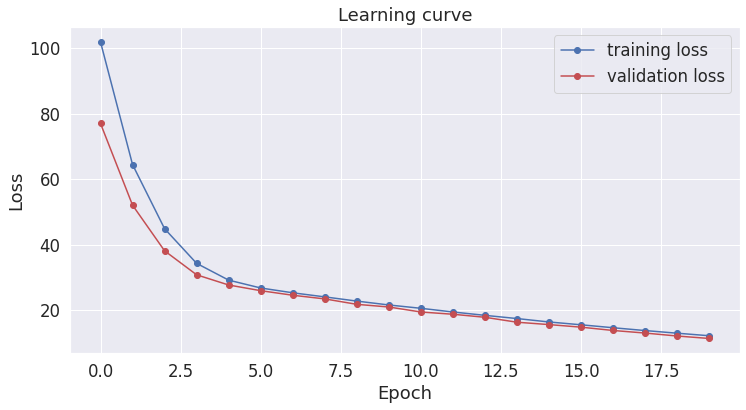

In [ ]:
history_dict = history_lstm.history

precision = history_dict['precision']
val_precision = history_dict['val_precision']
recall = history_dict['recall']
val_recall = history_dict['val_recall']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(precision) + 1)

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss, 'b-o', label="training loss")
plt.plot(val_loss, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

#### F1 Score & Precision & Recall & Subset Accuracy & Hamming Loss & Classification Report

In [ ]:
# Model Evaluation - Loss, Precision, Recall
results = model_lstm.evaluate(X_test, multi_label_test)
print("Test Precision: {}".format(round(results[1], 3)))
print("Test Recall: {}".format(round(results[2], 3)))

# Predictions
pred_labels = model_lstm.predict(X_test)

multi_preds = pred_labels >= 0.10
multi_preds = multi_preds.astype(int)

# Average Precision Score
avp = average_precision_score(multi_label_test, multi_preds)
print("Test Average Precision Score: {}".format(round(avp)))
# Subset accuracy
print('Subset accuracy: {0}'.format(round(accuracy_score(multi_label_test, multi_preds, normalize=True, sample_weight=None), 3)))
# Hamming loss (smaller is better)
print('Hamming loss: {0}'.format(round(hamming_loss(multi_label_test, multi_preds), 3)))

# Classification Report
df_pred = pd.DataFrame(pred_labels)
df_pred_clean = df_pred.apply(lambda x: [0 if y <= 0.10 else 1 for y in x])
pred_clean = np.array(df_pred_clean)

pred_bools_lstm = (pred_clean == 1)[:]
true_bools = (multi_label_test == 1)
clf_report = classification_report(true_bools, pred_bools_lstm)
print('Classification Report')
print(clf_report)

19/19 [==============================] - 0s 7ms/step - loss: 11.4430 - precision: 0.0000e+00 - recall: 0.0000e+00
Test Precision: 0.0
Test Recall: 0.0
Test Average Precision Score: 0.0
Subset accuracy: 0.002
Hamming loss: 0.21
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        57
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00        21
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00        22
           5       0.39      1.00      0.56       226
           6       0.00      0.00      0.00        48
           7       0.00      0.00      0.00        13
           8       0.24      1.00      0.39       142
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00        21
          11       0.25      1.00      0.40       145

   micro avg       0.29      0.69      0.41    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Multi Input LSTM Model

In [ ]:
text = Input(shape = (max_text,), name = 'text')
aspect = Input(shape = (17,), name = 'aspect')

text_embed = Embedding(output_dim=100, input_dim=len(word_index)+1, 
              input_length=max_text, weights=[embedding_matrix], 
              trainable=True)(text)
textLayers = LSTM(64, dropout=0.25, recurrent_dropout=0.25,
                  kernel_regularizer=l2(0.5), recurrent_regularizer=l2(0.5), bias_regularizer=l2(0.5))(text_embed)
textLayers = Dropout(0.25)(textLayers)

    
aspect_embed = Embedding(output_dim=100, input_dim=len(word_index)+1, 
              input_length=17, weights=[embedding_matrix], 
              trainable=True)(aspect)
aspectLayers = LSTM(64, return_sequences = False)(aspect_embed)
aspectLayers = Dropout(0.25)(aspectLayers)
    
  
allLayers = tf.keras.layers.concatenate([textLayers, aspectLayers])
output = Dense(12, activation = 'softmax', name = 'output')(allLayers)
    
model_multi_lstm = Model(inputs = [text, aspect], outputs = output)

model_multi_lstm.compile(optimizer='adam', 
                    loss='categorical_crossentropy',
                   metrics = [Precision(), Recall()])

history_multi_lstm = model_multi_lstm.fit([X_train, X_aspect], multi_label, validation_split=0.1,
                              batch_size = 64, epochs = 20,
                              callbacks = [EarlyStopping(monitor="val_loss", patience=1)])

Epoch 1/20
25/25 [==============================] - 3s 125ms/step - loss: 113.8715 - precision_1: 0.3000 - recall_1: 0.0029 - val_loss: 88.4586 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/20
25/25 [==============================] - 2s 85ms/step - loss: 73.9631 - precision_1: 0.4130 - recall_1: 0.0187 - val_loss: 59.6007 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/20
25/25 [==============================] - 2s 83ms/step - loss: 51.8209 - precision_1: 0.4060 - recall_1: 0.0265 - val_loss: 43.8132 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/20
25/25 [==============================] - 2s 83ms/step - loss: 39.7510 - precision_1: 0.3842 - recall_1: 0.0334 - val_loss: 35.2310 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 5/20
25/25 [==============================] - 2s 82ms/step - loss: 33.0756 - precision_1: 0.3780 - recall_1: 0.0305 - val_loss: 30.3898 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epo

### Evaluation

#### Graphs

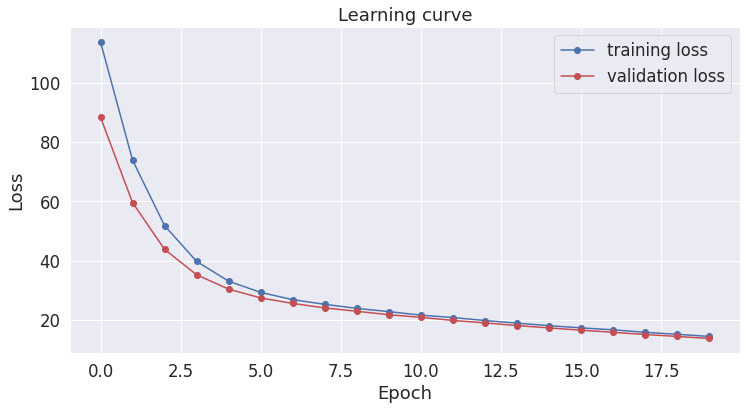

In [ ]:
history_dict = history_multi_lstm.history

precision = history_dict['precision_1']
val_precision = history_dict['val_precision_1']
recall = history_dict['recall_1']
val_recall = history_dict['val_recall_1']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(precision) + 1)

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss, 'b-o', label="training loss")
plt.plot(val_loss, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

#### F1 Score & Precision & Recall & Subset Accuracy & Hamming Loss & Classification Report

In [ ]:
# Model Evaluation - Loss, Precision, Recall
results = model_multi_lstm.evaluate([X_test, X_aspect_test], multi_label_test)

print("Test Precision: {}".format(round(results[1], 3)))
print("Test Recall: {}".format(round(results[2], 3)))

# Predictions
pred_labels = model_multi_lstm.predict([X_test, X_aspect_test])

multi_preds = pred_labels >= 0.10
multi_preds = multi_preds.astype(int)

# Average Precision Score
avp = average_precision_score(multi_label_test, multi_preds)
print("Test Average Precision Score: {}".format(round(avp)))
# Subset accuracy
print('Subset accuracy: {0}'.format(round(accuracy_score(multi_label_test, multi_preds, normalize=True, sample_weight=None), 3)))
# Hamming loss (smaller is better)
print('Hamming loss: {0}'.format(round(hamming_loss(multi_label_test, multi_preds), 3)))

# Classification Report
df_pred = pd.DataFrame(pred_labels)
df_pred_clean = df_pred.apply(lambda x: [0 if y <= 0.10 else 1 for y in x])
pred_clean = np.array(df_pred_clean)
pred_bools_multi_lstm = (pred_clean == 1)[:]
true_bools = (multi_label_test == 1)
clf_report = classification_report(true_bools, pred_bools_multi_lstm)
print('Classification Report')
print(clf_report)

19/19 [==============================] - 0s 8ms/step - loss: 13.7779 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Test Precision: 0.0
Test Recall: 0.0
Test Average Precision Score: 0.0
Subset accuracy: 0.002
Hamming loss: 0.21
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        57
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00        21
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00        22
           5       0.39      1.00      0.56       226
           6       0.00      0.00      0.00        48
           7       0.00      0.00      0.00        13
           8       0.24      1.00      0.39       142
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00        21
          11       0.25      1.00      0.40       145

   micro avg       0.29      0.69      0.41

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## BiLSTM Model

In [ ]:
text = Input(shape = (max_text,), name = 'text')
text_embed = Embedding(output_dim=100, input_dim=len(word_index)+1, 
              input_length=max_text, weights=[embedding_matrix], 
              trainable=True)(text)
textLayers = Bidirectional(LSTM(64, dropout=0.25, recurrent_dropout=0.25,
                  kernel_regularizer=l2(0.5), recurrent_regularizer=l2(0.5), bias_regularizer=l2(0.5)))(text_embed)
textLayers = Dropout(0.25)(textLayers)
output = Dense(12, activation = 'softmax', name = 'output')(textLayers)

model_bilstm = Model(inputs = text, outputs = output)
model_bilstm.compile(optimizer='rmsprop', 
                    loss='categorical_crossentropy',
                    metrics = [Precision(), Recall()])

history_bilstm = model_bilstm.fit(X_train, multi_label, validation_split=0.1,
                              batch_size = 64, epochs = 20,
                              callbacks = [EarlyStopping(monitor="val_loss", patience=1)])

Epoch 1/20
25/25 [==============================] - 4s 158ms/step - loss: 200.4065 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 151.2831 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/20
25/25 [==============================] - 3s 126ms/step - loss: 125.8632 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 101.1815 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/20
25/25 [==============================] - 3s 124ms/step - loss: 86.7976 - precision_2: 0.4667 - recall_2: 0.0034 - val_loss: 73.2257 - val_precision_2: 0.3274 - val_recall_2: 0.2477
Epoch 4/20
25/25 [==============================] - 3s 121ms/step - loss: 65.6652 - precision_2: 0.4578 - recall_2: 0.0187 - val_loss: 58.9306 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 5/20
25/25 [==============================] - 3s 117ms/step - loss: 55.4380 - precision_2: 0.3571 - recall_2: 0.0049 - val_loss: 52.4746 - val_precision_2: 0.3772 - val_recall_2: 0.1

###Evaluation

#### Graphs

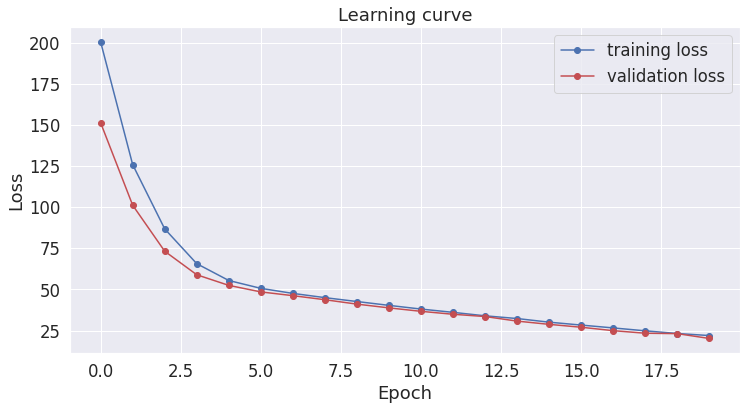

In [ ]:
history_dict = history_bilstm.history

precision = history_dict['precision_2']
val_precision = history_dict['val_precision_2']
recall = history_dict['recall_2']
val_recall = history_dict['val_recall_2']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(precision) + 1)

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss, 'b-o', label="training loss")
plt.plot(val_loss, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

#### F1 Score & Precision & Recall & Subset Accuracy & Hamming Loss & Classification Report

In [ ]:
# Model Evaluation - Loss, Precision, Recall
results = model_bilstm.evaluate(X_test, multi_label_test)

print("Test Precision: {}".format(round(results[1], 3)))
print("Test Recall: {}".format(round(results[2], 3)))

# Predictions
pred_labels = model_bilstm.predict(X_test)

multi_preds = pred_labels >= 0.10
multi_preds = multi_preds.astype(int)

# Average Precision Score
avp = average_precision_score(multi_label_test, multi_preds)
print("Test Average Precision Score: {}".format(round(avp)))
# Subset accuracy
print('Subset accuracy: {0}'.format(round(accuracy_score(multi_label_test, multi_preds, normalize=True, sample_weight=None), 3)))
# Hamming loss (smaller is better)
print('Hamming loss: {0}'.format(round(hamming_loss(multi_label_test, multi_preds), 3)))

# Classification Report
df_pred = pd.DataFrame(pred_labels)
df_pred_clean = df_pred.apply(lambda x: [0 if y <= 0.10 else 1 for y in x])
pred_clean = np.array(df_pred_clean)

pred_bools_bilstm = (pred_clean == 1)[:]
true_bools = (multi_label_test == 1)
clf_report = classification_report(true_bools, pred_bools_bilstm)
print('Classification Report')
print(clf_report)

19/19 [==============================] - 0s 12ms/step - loss: 20.2653 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Test Precision: 0.0
Test Recall: 0.0
Test Average Precision Score: 0.0
Subset accuracy: 0.0
Hamming loss: 0.277
Classification Report
              precision    recall  f1-score   support

           0       0.10      1.00      0.18        57
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00        21
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00        22
           5       0.39      1.00      0.56       226
           6       0.00      0.00      0.00        48
           7       0.00      0.00      0.00        13
           8       0.24      1.00      0.39       142
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00        21
          11       0.25      1.00      0.40       145

   micro avg       0.24      0.77      0.37

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Multi Input BiLSTM Model

In [ ]:
text = Input(shape = (max_text,), name = 'text')
aspect = Input(shape = (17,), name = 'aspect')

text_embed = Embedding(output_dim=100, input_dim=len(word_index)+1, 
              input_length=max_text, weights=[embedding_matrix], 
              trainable=True)(text)
textLayers = LSTM(64, dropout=0.25, recurrent_dropout=0.25,
                  kernel_regularizer=l2(0.5), recurrent_regularizer=l2(0.5), bias_regularizer=l2(0.5))(text_embed)
textLayers = Dropout(0.25)(textLayers)

    
aspect_embed = Embedding(output_dim=100, input_dim=len(word_index)+1, 
              input_length=17, weights=[embedding_matrix], 
              trainable=True)(aspect)
aspectLayers = LSTM(64, return_sequences = False)(aspect_embed)
aspectLayers = Dropout(0.25)(aspectLayers)
    
  
allLayers = tf.keras.layers.concatenate([textLayers, aspectLayers])
output = Dense(12, activation = 'softmax', name = 'output')(allLayers)
    
model_multi_bilstm = Model(inputs = [text, aspect], outputs = output)

model_multi_bilstm.compile(optimizer='adam', 
                    loss='categorical_crossentropy',
                   metrics = [Precision(), Recall()])

history_multi_bilstm = model_multi_bilstm.fit([X_train, X_aspect], multi_label, validation_split=0.1,
                              batch_size = 64, epochs = 20,
                              callbacks = [EarlyStopping(monitor="val_loss", patience=1)])

Epoch 1/20
25/25 [==============================] - 4s 149ms/step - loss: 113.4855 - precision_3: 0.4043 - recall_3: 0.0093 - val_loss: 88.0768 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/20
25/25 [==============================] - 3s 109ms/step - loss: 73.6471 - precision_3: 0.4333 - recall_3: 0.0192 - val_loss: 59.3257 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/20
25/25 [==============================] - 3s 110ms/step - loss: 51.5810 - precision_3: 0.3963 - recall_3: 0.0319 - val_loss: 43.6764 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 4/20
25/25 [==============================] - 2s 94ms/step - loss: 39.6031 - precision_3: 0.4304 - recall_3: 0.0668 - val_loss: 35.0460 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 5/20
25/25 [==============================] - 2s 85ms/step - loss: 32.9740 - precision_3: 0.3851 - recall_3: 0.0329 - val_loss: 30.2563 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
E

### Evaluation

#### Graphs

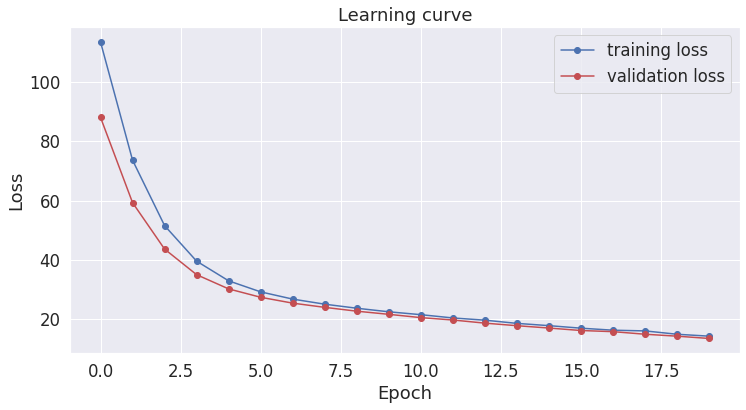

In [ ]:
history_dict = history_multi_bilstm.history

precision = history_dict['precision_3']
val_precision = history_dict['val_precision_3']
recall = history_dict['recall_3']
val_recall = history_dict['val_recall_3']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(precision) + 1)

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss, 'b-o', label="training loss")
plt.plot(val_loss, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

#### F1 Score & Precision & Recall & Subset Accuracy & Hamming Loss & Classification Report

In [ ]:
# Model Evaluation - Loss, Precision, Recall
results = model_multi_bilstm.evaluate([X_test, X_aspect_test], multi_label_test)
#f1_score = 2 * (results[1] * results[2])/(results[1] + results[2])

print("Test Precision: {}".format(round(results[1], 3)))
print("Test Recall: {}".format(round(results[2], 3)))

# Predictions
pred_labels = model_multi_bilstm.predict([X_test, X_aspect_test])

multi_preds = pred_labels >= 0.10
multi_preds = multi_preds.astype(int)

# Average Precision Score
avp = average_precision_score(multi_label_test, multi_preds)
print("Test Average Precision Score: {}".format(round(avp)))
# Subset accuracy
print('Subset accuracy: {0}'.format(round(accuracy_score(multi_label_test, multi_preds, normalize=True, sample_weight=None), 3)))
# Hamming loss (smaller is better)
print('Hamming loss: {0}'.format(round(hamming_loss(multi_label_test, multi_preds), 3)))

# Classification Report
df_pred = pd.DataFrame(pred_labels)
df_pred_clean = df_pred.apply(lambda x: [0 if y <= 0.10 else 1 for y in x])
pred_clean = np.array(df_pred_clean)

pred_bools_multi_bilstm = (pred_clean == 1)[:]
true_bools = (multi_label_test == 1)
clf_report = classification_report(true_bools, pred_bools_multi_bilstm)
print('Classification Report:')
print(clf_report)

19/19 [==============================] - 0s 9ms/step - loss: 13.6251 - precision_3: 0.8718 - recall_3: 0.0458
Test Precision: 0.872
Test Recall: 0.046
Test Average Precision Score: 0.0
Subset accuracy: 0.003
Hamming loss: 0.252
Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.86      0.22        57
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00        21
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00        22
           5       0.39      1.00      0.56       226
           6       1.00      0.02      0.04        48
           7       0.00      0.00      0.00        13
           8       0.24      1.00      0.39       142
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00        21
          11       0.25      1.00      0.40       145

   micro avg       0.26      0.76      0.39  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## CNN Model

In [ ]:
cnn_model = Sequential()
cnn_model.add(Embedding(output_dim=100, input_dim=len(word_index)+1, input_length = max_text,
                       weights = [embedding_matrix], trainable = True))

cnn_model.add(Conv1D(filters = 250,
                     kernel_size = 3, 
                     padding = 'valid'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPooling1D(pool_size=2, padding='same'))
cnn_model.add(Dropout(0.4))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='linear'))

cnn_model.add(Dense(12, activation='softmax'))
cnn_model.compile(loss = "categorical_crossentropy", 
              optimizer = "adam", 
              metrics=[Precision(), Recall()]) 

history_cnn = cnn_model.fit(X_train, multi_label, validation_split=0.1,
                              batch_size = 64, epochs = 20,
                              callbacks = [EarlyStopping(monitor="val_loss", patience=1)])

Epoch 1/20
25/25 [==============================] - 1s 25ms/step - loss: 4.4034 - precision_4: 0.3646 - recall_4: 0.1586 - val_loss: 6.5293 - val_precision_4: 0.1170 - val_recall_4: 0.0901
Epoch 2/20
25/25 [==============================] - 0s 12ms/step - loss: 20.6484 - precision_4: 0.2918 - recall_4: 0.2014 - val_loss: 64.4468 - val_precision_4: 0.2924 - val_recall_4: 0.2252


### Evaluation

#### Graphs

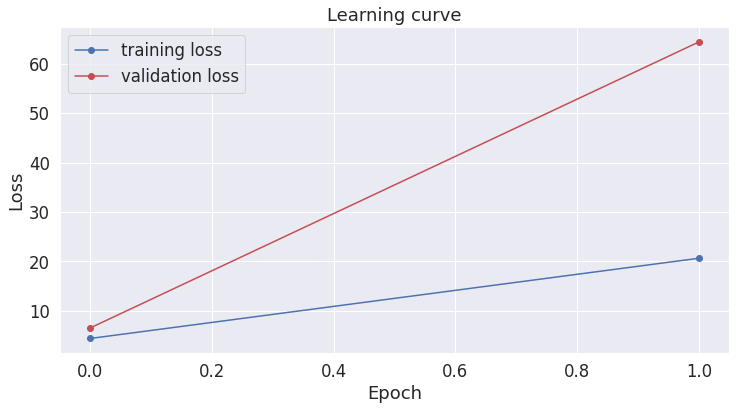

In [ ]:
history_dict = history_cnn.history

precision = history_dict['precision_4']
val_precision = history_dict['val_precision_4']
recall = history_dict['recall_4']
val_recall = history_dict['val_recall_4']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(precision) + 1)

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss, 'b-o', label="training loss")
plt.plot(val_loss, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

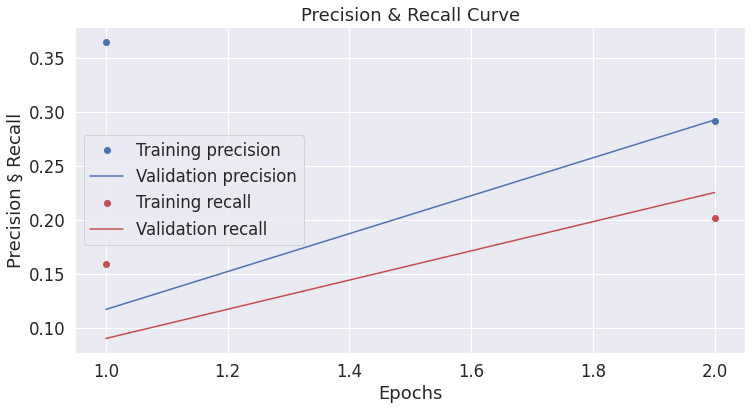

In [ ]:
plt.clf()   # clear figure

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(epochs, precision, 'bo', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.plot(epochs, recall, 'ro', label='Training recall')
plt.plot(epochs, val_recall, 'r', label='Validation recall')
plt.title('Precision & Recall Curve')
plt.xlabel('Epochs')
plt.ylabel('Precision § Recall')
plt.legend()

plt.show()

#### F1 Score & Precision & Recall & Subset Accuracy & Hamming Loss & Classification Report

In [ ]:
# Model Evaluation - Loss, Precision, Recall
results = cnn_model.evaluate(X_test, multi_label_test)
f1_score = 2 * (results[1] * results[2])/(results[1] + results[2])

print("Test F1-Score: {}".format(round(f1_score,3)))
print("Test Precision: {}".format(round(results[1], 3)))
print("Test Recall: {}".format(round(results[2], 3)))

# Predictions
pred_labels = cnn_model.predict(X_test)

multi_preds = pred_labels >= 0.10
multi_preds = multi_preds.astype(int)

# Average Precision Score
avp = average_precision_score(multi_label_test, multi_preds)
print("Test Average Precision Score: {}".format(round(avp)))
# Subset accuracy
print('Subset accuracy: {0}'.format(round(accuracy_score(multi_label_test, multi_preds, normalize=True, sample_weight=None), 3)))
# Hamming loss (smaller is better)
print('Hamming loss: {0}'.format(round(hamming_loss(multi_label_test, multi_preds), 3)))

# Classification Report
df_pred = pd.DataFrame(pred_labels)
df_pred_clean = df_pred.apply(lambda x: [0 if y <= 0.10 else 1 for y in x])
pred_clean = np.array(df_pred_clean)

pred_bools_cnn = (pred_clean == 1)[:]
true_bools = (multi_label_test == 1)
clf_report = classification_report(true_bools, pred_bools_cnn)
print('Classification Report')
print(clf_report)

19/19 [==============================] - 0s 2ms/step - loss: 80.1814 - precision_4: 0.1312 - recall_4: 0.1036
Test F1-Score: 0.116
Test Precision: 0.131
Test Recall: 0.104
Test Average Precision Score: 0.0
Subset accuracy: 0.061
Hamming loss: 0.179
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        57
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00        21
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00        22
           5       0.00      0.00      0.00       226
           6       0.00      0.00      0.00        48
           7       0.00      0.00      0.00        13
           8       0.00      0.00      0.00       142
           9       0.00      0.00      0.00        33
          10       0.03      0.71      0.06        21
          11       0.34      0.54      0.42       145

   micro avg       0.13  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Output Frame for NNs

In [ ]:
# Convert the boolean vectors to the prediction indexes
true_label_idxs, lstm_pred_label_idxs, multi_lstm_pred_label_idxs, bilstm_pred_label_idxs, multi_bilstm_pred_label_idxs, cnn_pred_label_idxs =[],[],[],[],[],[]
for vals in true_bools:
  true_label_idxs.append(np.where(vals)[0].flatten().tolist())
for vals in pred_bools_lstm:
  lstm_pred_label_idxs.append(np.where(vals)[0].flatten().tolist())
for vals in pred_bools_multi_lstm:
  multi_lstm_pred_label_idxs.append(np.where(vals)[0].flatten().tolist())
for vals in pred_bools_bilstm:
  bilstm_pred_label_idxs.append(np.where(vals)[0].flatten().tolist())
for vals in pred_bools_multi_bilstm:
  multi_bilstm_pred_label_idxs.append(np.where(vals)[0].flatten().tolist())
for vals in pred_bools_cnn:
  cnn_pred_label_idxs.append(np.where(vals)[0].flatten().tolist())

# Convert the indexes to label names 
true_label_texts, lstm_label_texts, multi_lstm_label_texts, bilstm_label_texts, multi_bilstm_label_texts, cnn_label_texts = [], [], [], [], [], []
for vals in true_label_idxs:
  if vals:
    true_label_texts.append([idx2label[val] for val in vals])
  else:
    true_label_texts.append(vals)

for vals in lstm_pred_label_idxs:
  if vals:
    lstm_label_texts.append([idx2label[val] for val in vals])
  else:
    lstm_label_texts.append(vals)

for vals in multi_lstm_pred_label_idxs:
  if vals:
    multi_lstm_label_texts.append([idx2label[val] for val in vals])
  else:
    multi_lstm_label_texts.append(vals)

for vals in bilstm_pred_label_idxs:
  if vals:
    bilstm_label_texts.append([idx2label[val] for val in vals])
  else:
    bilstm_label_texts.append(vals)

for vals in multi_bilstm_pred_label_idxs:
  if vals:
    multi_bilstm_label_texts.append([idx2label[val] for val in vals])
  else:
    multi_bilstm_label_texts.append(vals)

for vals in cnn_pred_label_idxs:
  if vals:
    cnn_label_texts.append([idx2label[val] for val in vals])
  else:
    cnn_label_texts.append(vals)

# Converting lists to df
nn_df = pd.DataFrame({'comment_text': test_Text, 'true_labels': true_label_texts, 'true_codes':true_label_idxs,
                            'lstm_labels':lstm_label_texts, 'lstm_codes':lstm_pred_label_idxs, 
                            'multi_lstm_labels':multi_lstm_label_texts, 'multi_lstm_codes':multi_lstm_pred_label_idxs,
                            'bilstm_labels':bilstm_label_texts, 'bilstm_codes':bilstm_pred_label_idxs, 
                            'multi_bilstm_labels':multi_bilstm_label_texts, 'multi_bilstm_codes':multi_bilstm_pred_label_idxs,
                            'cnn_labels':cnn_label_texts, 'cnn_codes':cnn_pred_label_idxs})
nn_df.to_csv('nn.csv')
nn_df.to_excel('nn.xlsx')
nn_df.head()

,comment_text,true_labels,true_codes,lstm_labels,lstm_codes,multi_lstm_labels,multi_lstm_codes,bilstm_labels,bilstm_codes,multi_bilstm_labels,multi_bilstm_codes,cnn_labels,cnn_codes
0,yum,[FOOD#QUALITY],[5],"[FOOD#QUALITY, RESTAURANT#GENERAL, SERVICE#GEN...","[5, 8, 11]","[FOOD#QUALITY, RESTAURANT#GENERAL, SERVICE#GEN...","[5, 8, 11]","[AMBIENCE#GENERAL, FOOD#QUALITY, RESTAURANT#GE...","[0, 5, 8, 11]","[FOOD#QUALITY, RESTAURANT#GENERAL, SERVICE#GEN...","[5, 8, 11]",[FOOD#QUALITY],[5]
1,serves really good sushi,[FOOD#QUALITY],[5],"[FOOD#QUALITY, RESTAURANT#GENERAL, SERVICE#GEN...","[5, 8, 11]","[FOOD#QUALITY, RESTAURANT#GENERAL, SERVICE#GEN...","[5, 8, 11]","[AMBIENCE#GENERAL, FOOD#QUALITY, RESTAURANT#GE...","[0, 5, 8, 11]","[FOOD#QUALITY, RESTAURANT#GENERAL, SERVICE#GEN...","[5, 8, 11]",[FOOD#QUALITY],[5]
2,not the biggest portions but adequate,[FOOD#STYLE_OPTIONS],[6],"[FOOD#QUALITY, RESTAURANT#GENERAL, SERVICE#GEN...","[5, 8, 11]","[FOOD#QUALITY, RESTAURANT#GENERAL, SERVICE#GEN...","[5, 8, 11]","[AMBIENCE#GENERAL, FOOD#QUALITY, RESTAURANT#GE...","[0, 5, 8, 11]","[FOOD#QUALITY, RESTAURANT#GENERAL, SERVICE#GEN...","[5, 8, 11]",[FOOD#QUALITY],[5]
3,green tea creme brulee is a must,[FOOD#QUALITY],[5],"[FOOD#QUALITY, RESTAURANT#GENERAL, SERVICE#GEN...","[5, 8, 11]","[FOOD#QUALITY, RESTAURANT#GENERAL, SERVICE#GEN...","[5, 8, 11]","[AMBIENCE#GENERAL, FOOD#QUALITY, RESTAURANT#GE...","[0, 5, 8, 11]","[FOOD#QUALITY, RESTAURANT#GENERAL, SERVICE#GEN...","[5, 8, 11]",[FOOD#QUALITY],[5]
4,do not leave the restaurant without it,[FOOD#QUALITY],[5],"[FOOD#QUALITY, RESTAURANT#GENERAL, SERVICE#GEN...","[5, 8, 11]","[FOOD#QUALITY, RESTAURANT#GENERAL, SERVICE#GEN...","[5, 8, 11]","[AMBIENCE#GENERAL, FOOD#QUALITY, RESTAURANT#GE...","[0, 5, 8, 11]","[FOOD#QUALITY, RESTAURANT#GENERAL, SERVICE#GEN...","[5, 8, 11]",[FOOD#QUALITY],[5]


# ELMO

## Model

In [ ]:
# In order to download the pretrained ELMO layer from the hub, lower the Tensorflow version
!pip install tensorflow==1.15.0
!pip install tensorflow_hub

     |████████████████████████████████| 412.3MB 31kB/s 
     |████████████████████████████████| 512kB 53.8MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 3.8MB 51.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=70026c84e65b053f79cd9f4c0e763cd62c1ea2634f37765be70d563243b26483
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninsta

In [ ]:
# Adjust the data into a proper format 
xtrain = np.array(train_Text)
ytrain = multi_label
xtest = np.array(test_Text)
ytest = multi_label_test

# Download the pretrained ELMO layer from Tensorflow hub
embed = hub.Module("https://tfhub.dev/google/elmo/2")
def ELMoEmbedding(x):
    return embed(tf.reshape(tf.cast(x, tf.string), [-1]), signature="default", as_dict=True)['default']

# Model Metrics
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# ELMO Model
def build_model(): 
    input_comment = Input(shape=(1,), dtype="string", name='input_comment')
    embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_comment)
    dense = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(embedding)
    pred = Dense(12, activation='sigmoid')(dense)
    model = Model(inputs=[input_comment], outputs=pred)
    model.compile(tf.keras.optimizers.Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy', recall_m,
                                                                                               precision_m, f1_m]) 
    return model
model_elmo = build_model()

# Fit the train data & Take predictions
earlystopping = EarlyStopping(monitor = "val_loss", mode = "min", patience = 1)
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history_elmo = model_elmo.fit(xtrain, ytrain,validation_data=(xtest, ytest), epochs=4, batch_size=32)
    results = model_elmo.evaluate(xtest, ytest)
    pred_labels = model_elmo.predict(xtest)
    multi_preds = pred_labels >= 0.10
    multi_preds = multi_preds.astype(int)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1708 samples, validate on 587 samples
Epoch 1/4
1708/1708 [==============================] - 73s 43ms/sample - loss: 3.2993 - acc: 0.3694 - recall_m: 0.7748 - precision_m: 0.2258 - f1_m: 0.3471 - val_loss: 2.9180 - val_acc: 0.5264 - val_recall_m: 0.7890 - val_precision_m: 0.2781 - val_f1_m: 0.4105
Epoch 2/4
1708/1708 [==============================] - 71s 42ms/sample - loss: 2.9390 - acc: 0.4543 - recall_m: 0.7374 - precision_m: 0.3214 - f1_m: 0.4456 - val_loss: 2.6929 - val_acc: 0.4140 - val_recall_m: 0.7124 - val_precision_m: 0.3716 - val_f1_m: 0.4878
Epoch 3/4
1708/1708 [==============================] - 76s 44ms/sample - loss: 2.6996 - acc: 0.4666 - recall_m: 0.6449 - precision_m: 0.4410 - f1_m: 0.5192 - val_loss: 2.4258 - val_acc: 0.5911 - val_recall_m: 0.6179 - val_precision_m: 0.5819 - val_f1_m: 0.5971
Epoch 4/4
587/587 [==============================] - 18s 31ms/sample - loss: 2.2308 - acc: 0.6269 - recall_m: 0.3478 - precision_m: 0.8368 - f1_m: 0.4818


## Evaluation

### Graphs

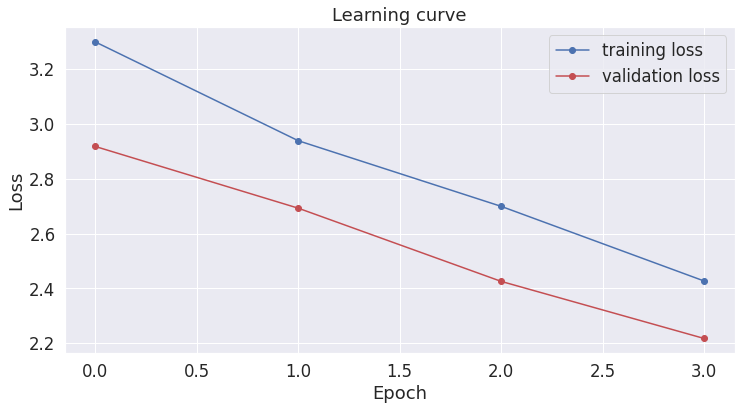

In [ ]:
history_dict = history_elmo.history

precision = history_dict['precision_m']
val_precision = history_dict['val_precision_m']
recall = history_dict['recall_m']
val_recall = history_dict['val_recall_m']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(precision) + 1)

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss, 'b-o', label="training loss")
plt.plot(val_loss, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

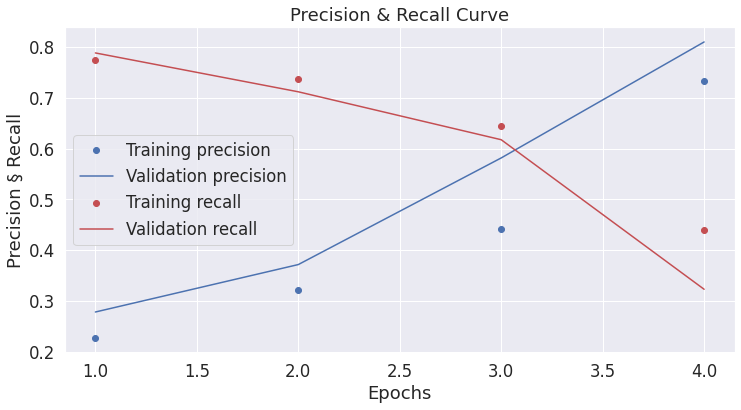

In [ ]:
plt.clf()   # clear figure

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(epochs, precision, 'bo', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.plot(epochs, recall, 'ro', label='Training recall')
plt.plot(epochs, val_recall, 'r', label='Validation recall')
plt.title('Precision & Recall Curve')
plt.xlabel('Epochs')
plt.ylabel('Precision § Recall')
plt.legend()

plt.show()

### F1 Score & Precision & Recall & Subset Accuracy & Hamming Loss & Classification Report

In [ ]:
# Model Evaluation - Loss, Precision, Recall
print("Test Accuracy: {}".format(round(results[1],3)))
print("Test Recall: {}".format(round(results[2], 3)))
print("Test Precision: {}".format(round(results[3], 3)))
print("Test F1 Score: {}".format(round(results[4], 3)))

# Average Precision Score
avp = average_precision_score(multi_label_test, multi_preds)
print("Test Average Precision Score: {}".format(round(avp)))
# Subset accuracy
print('Subset accuracy: {0}'.format(round(accuracy_score(multi_label_test, multi_preds, normalize=True, sample_weight=None), 3)))
# Hamming loss (smaller is better)
print('Hamming loss: {0}'.format(round(hamming_loss(multi_label_test, multi_preds), 3)))

# Classification Report
df_pred = pd.DataFrame(pred_labels)
df_pred_clean = df_pred.apply(lambda x: [0 if y <= 0.10 else 1 for y in x])
pred_clean = np.array(df_pred_clean)

pred_bools_elmo = (pred_clean == 1)[:]
true_bools = (multi_label_test == 1)
clf_report = classification_report(true_bools, pred_bools_elmo)
print('Classification Report')
print(clf_report)

Test Accuracy: 0.6269999742507935
Test Recall: 0.3479999899864197
Test Precision: 0.8370000123977661
Test F1 Score: 0.4819999933242798
Test Average Precision Score: 0.0
Subset accuracy: 0.111
Hamming loss: 0.219


## Output Frame for ELMO

In [ ]:
# Convert the boolean vectors to the prediction indexes
true_label_idxs, elmo_pred_label_idx =[],[]
for vals in true_bools:
  true_label_idxs.append(np.where(vals)[0].flatten().tolist())
for vals in pred_bools_elmo:
  elmo_pred_label_idx.append(np.where(vals)[0].flatten().tolist())

# Convert the indexes to label names
idx2label = dict(zip(range(12),categories))
true_label_texts, elmo_label_texts= [], []
for vals in true_label_idxs:
  if vals:
    true_label_texts.append([idx2label[val] for val in vals])
  else:
    true_label_texts.append(vals)

for vals in elmo_pred_label_idx:
  if vals:
    elmo_label_texts.append([idx2label[val] for val in vals])
  else:
    elmo_label_texts.append(vals)

# Converting lists to df
elmo_df = pd.DataFrame({'comment_text': test_Text, 'true_labels': true_label_texts, 'true_codes':true_label_idxs,
                            'elmo_labels':elmo_label_texts, 'elmo_codes':elmo_pred_label_idx})
elmo_df.to_csv('elmo.csv')
elmo_df.to_excel('elmo.xlsx')
elmo_df.head()

,comment_text,true_labels,true_codes,elmo_labels,elmo_codes
0,yum,[FOOD#QUALITY],[5],[],[]
1,serves really good sushi,[FOOD#QUALITY],[5],[FOOD#QUALITY],[5]
2,not the biggest portions but adequate,[FOOD#STYLE_OPTIONS],[6],"[AMBIENCE#GENERAL, FOOD#PRICES, FOOD#QUALITY, ...","[0, 4, 5, 6, 10, 11]"
3,green tea creme brulee is a must,[FOOD#QUALITY],[5],"[FOOD#QUALITY, FOOD#STYLE_OPTIONS]","[5, 6]"
4,do not leave the restaurant without it,[FOOD#QUALITY],[5],"[FOOD#QUALITY, RESTAURANT#GENERAL, RESTAURANT#...","[5, 8, 9, 11]"
